In [0]:
# Installation cell
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add Plots; add PyPlot; add IJulia; add Knet;"'
julia -e 'using Pkg; pkg"build Knet;"'

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


In [0]:
using Knet
# Test if Knet is using gpu
Knet.gpu()

┌ Info: Precompiling Knet [1902f260-5fb4-5aff-8c31-6271790ab950]
└ @ Base loading.jl:1273
┌ Warning: You are using CUDNN 7.6.5 for CUDA 10.1.0 with CUDA toolkit 10.0.130; these might be incompatible.
└ @ CuArrays /root/.julia/packages/CuArrays/A6GUx/src/CuArrays.jl:128


0

In [3]:
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots", "FileIO", "Images", "TestImages","PyCall", "ImageMagick", "Colors", "Random"); haskey(Pkg.installed(),p) || Pkg.add(p); end
Pkg.update("Knet")
using Base.Iterators: flatten
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, progress, sgd, dropout, relu, Data, Param
#using ImageView;
using Knet, ImageMagick, Colors, Images, Random, TestImages

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


In [0]:
methods(testimage)

# 1 method for generic function "testimage":
[1] testimage(filename; download_only, ops...) in TestImages at /root/.julia/packages/TestImages/LDLMy/src/TestImages.jl:70

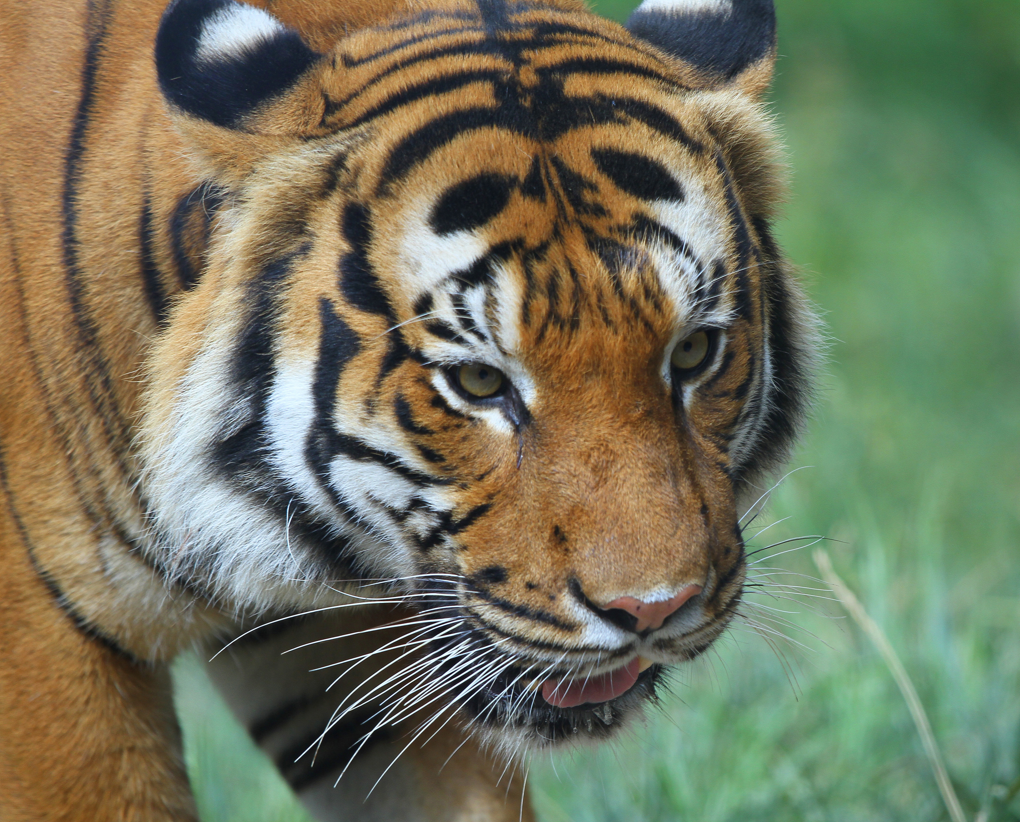

In [0]:
x = load("0010x2.png")

In [8]:
r = KnetArray{Float32}(rand(5, 5, 3, 1))

5×5×3×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.179863  0.605457   0.224121  0.296516  0.736183
 0.59125   0.29215    0.802404  0.458393  0.708924
 0.422559  0.0499567  0.396759  0.567983  0.166866
 0.415122  0.923196   0.767686  0.511547  0.862238
 0.143404  0.215629   0.530019  0.548867  0.230475

[:, :, 2, 1] =
 0.36417   0.103616  0.100143  0.755573   0.817401
 0.233471  0.77187   0.957198  0.185638   0.563359
 0.876101  0.845662  0.580079  0.575266   0.738925
 0.302935  0.340043  0.330329  0.848055   0.666106
 0.502597  0.498462  0.305025  0.0457973  0.765783

[:, :, 3, 1] =
 0.131511  0.793848  0.525392  0.722053   0.200513
 0.535333  0.747317  0.960098  0.0921476  0.430695
 0.4365    0.541829  0.272689  0.640551   0.508101
 0.941772  0.909304  0.590089  0.48586    0.277092
 0.598151  0.56615   0.596036  0.633405   0.637952

In [0]:
;ls

0010x2.png
sample_data


In [0]:
function get_filenames(dataset_dir::String, dataset_type::String)
    file_names = Array{String}([])
        data = dataset_dir*dataset_type*"/"
        dirs = readdir(data)
        for dir in dirs
            full_dir = data*dir
            if isfile(full_dir)
                push!(file_names, full_dir)
            elseif isdir(full_dir)
                full_dir = full_dir*"/"*first(readdir(full_dir))
                isfile(full_dir) && push!(file_names, full_dir)
            end
        end
    return file_names
end

get_filenames (generic function with 1 method)

In [0]:
train_data_lr= get_filenames("/content/sample_data/", "train_lr_bic_x2")
train_data_hr= get_filenames("/content/sample_data/", "train_hr")
test_data_lr= get_filenames("/content/sample_data/", "test_lr_bic_x2")
test_data_hr= get_filenames("/content/sample_data/", "test_hr")



5-element Array{String,1}:
 "/content/sample_data/test_hr/0801.png"
 "/content/sample_data/test_hr/0802.png"
 "/content/sample_data/test_hr/0803.png"
 "/content/sample_data/test_hr/0804.png"
 "/content/sample_data/test_hr/0805.png"

In [0]:
function minibatch(X, Y, bs=3)
	#takes raw input (X) and gold labels (Y)
	#returns list of minibatches (x, y)
	data = Any[]

	#start of step 1
	for i=1:round(Int,size(X,2)/bs)
		X_el = X[:,(i-1)*bs+1:i*bs]
		Y_el = Y[:,(i-1)*bs+1:i*bs]
		data_el = (X_el,Y_el)
		push!(data,data_el)
	end

	return data
end

minibatch (generic function with 2 methods)

In [0]:
function create_x(x_folder,imsize,n)
	x = zeros(Float32,imsize .^ 2 .* 3,1)
	image_list = readdir(x_folder)
	for i=1:n
		cur_im = load(string(x_folder,image_list[i]))
		cur_im = convert(Array{Float32},channelview(cur_im))
		if ndims(cur_im)==2
      print("yes")
			tmp = zeros(3,size(cur_im,1),size(cur_im,2))
			tmp[1,:,:] = cur_im
			tmp[2,:,:] = cur_im
			tmp[3,:,:] = cur_im
			cur_im = tmp
		end
			cur_im = permutedims(cur_im,[2 3 1])
		# pad zeros to make image square
		if size(cur_im,2) < imsize
			cur_im = hcat(zeros(Float32,size(cur_im,1),Int64(floor((imsize-size(cur_im,2))/2)),size(cur_im,3)), cur_im, zeros(Float32,size(cur_im,1),Int64(ceil((imsize-size(cur_im,2))/2)),size(cur_im,3)))
		end
		if size(cur_im,1) < imsize
			cur_im = vcat(zeros(Float32,Int64(floor((imsize-size(cur_im,1))/2)),size(cur_im,2),size(cur_im,3)), cur_im, zeros(Float32,Int64(ceil((imsize-size(cur_im,1))/2)),size(cur_im,2),size(cur_im,3)))
		end
		cur_im_vec = vec(cur_im)
		x = hcat(x,cur_im_vec)
	end
	return x[:,2:end]
end

create_x (generic function with 1 method)

In [0]:
#trn_folder= "/content/"

In [0]:
xtrn = create_x(trn_folder*"train_lr_bic_x2/",1020,15);

In [0]:
xtst = create_x(trn_folder*"test_lr_bic_x2/",1020,5);
ytrn = create_x(trn_folder*"train_hr/",2040,15);
ytst = create_x(trn_folder*"test_hr/",2040,5);

In [0]:
bs = 5
trn_data = minibatch(xtrn, ytrn, bs);


In [0]:
struct ConvModelRelu; w; b; f; end
ConvModelRelu(w1,w2,cx,cy,f=relu) = ConvModelRelu(param(w1,w2,cx,cy), param0(1,1,cy,1), f)
(c::ConvModelRelu)(x) = c.f.(conv4(c.w, x; padding=(1, 1)) .+ c.b)

In [0]:
struct ConvModel; w; b; end
ConvModel(w1,w2,cx,cy) = ConvModel(param(w1,w2,cx,cy), param0(1,1,cy,1))
(c::ConvModel)(x) = (conv4(c.w, x; padding=(1, 1)) .+ c.b)


In [0]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)


In [0]:
model1= Chain(ConvModel(3,3,3,4), ConvModelRelu(3,3,4,4))

Chain((ConvModel(P(KnetArray{Float32,4}(3,3,3,4)), P(KnetArray{Float32,4}(1,1,4,1))), ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu)))

In [0]:
struct ResBlock3; chainModel; _s; ResBlock3(chainModel,_s) = new(chainModel,_s); end
ResBlock3(w1,w2,cx,cy,s=0.1,f=relu) = begin
                          rb3 = ResBlock3(Chain(
                          ConvModelRelu(param(w1,w2,cx,cy), param0(1,1,cy,1), f),
                          ConvModel(param(w1,w2,cx,cy), param0(1,1,cy,1))),s)
                          #rb3.chainModel = Chain(
                          #ConvModelRelu(param(w1,w2,cx,cy), param0(1,1,cy,1), f),
                          #ConvModel(param(w1,w2,cx,cy), param0(1,1,cy,1)))
                          #_s = s
                          rb3
                          end
(rb::ResBlock3)(x) = rb._s * rb.chainModel(x) .+ x



In [13]:
rb3 = ResBlock3(3,3,4,4)

ResBlock3(Chain((ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1))))), 0.1)

In [0]:
rb3(x)

4545

5×5×4×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
  0.276315   -0.287037   -0.295147   0.169756   -0.108832 
 -0.0181531   0.370936   -0.114722  -0.115486   -0.0206076
  0.360907    0.0504488  -0.325543  -0.448336   -0.303229 
  0.200725   -0.232791    0.187859  -0.17607    -0.201581 
  0.205748   -0.150906   -0.218056  -0.0452968  -0.34809  

[:, :, 2, 1] =
 0.408238   0.213803  -0.0300913   0.167472     0.470107 
 0.197234   0.737593  -0.198751   -0.12951     -0.0900516
 0.169808  -0.275473  -0.355725    0.508553     0.196768 
 0.38739   -0.294645   0.147706    0.107592     0.160164 
 0.310218  -0.441307  -0.204622   -0.00175399   0.328468 

[:, :, 3, 1] =
  0.626167   0.421497     0.533871   0.428054   0.194535
  0.567488  -0.234043     0.38046    0.593594  -0.515551
  0.383602   0.164344     0.458095  -0.138722   0.379617
  0.190487   0.00183504   0.261539  -0.179159  -0.266867
 -0.196414  -0.433624    -0.620352  -0.229653  -0.515144

[:, :, 4, 1] =
 -0.16955   -0.530024  -0.527033   0.

In [0]:
struct ChainResBlock2; resblockChain::Chain; lastConvLayer; ChainResBlock2(rbc, lcv) = new(rbc,lcv); end
ChainResBlock2(w1,w2,cx,cy,n_iter,s=0.1,f=relu) = begin
                                              resblocks = []
                                                for i in 1:n_iter
                                                push!(resblocks, ResBlock3(w1,w2,cx,cy,s,f))
                                              end
                                              print(n_iter)
                                              mychain = Chain(resblocks...)
                                              crb = ChainResBlock2(mychain,ConvModel(w1,w2,cx,cy))
                                              crb
                                              end
(crb::ChainResBlock2)(x) = crb.lastConvLayer(crb.resblockChain(x)) .+ x

In [17]:
ty = ChainResBlock2(3,3,4,4,16)

16

ChainResBlock2(Chain((ResBlock3(Chain((ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1))))), 0.1), ResBlock3(Chain((ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1))))), 0.1), ResBlock3(Chain((ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1))))), 0.1), ResBlock3(Chain((ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1))))), 0.1), ResBlock3(Chain((ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1

In [18]:
ty(x)

5×5×4×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 -0.285035   0.738689    0.89845    -0.0746266  0.537358
  0.190626   0.13097    -0.076079    0.297049   0.658932
 -0.73319   -0.5507      0.0391321   0.542557   0.568989
 -0.224514   0.58257     0.361681   -0.180484   1.02772 
 -0.40266   -0.0808558   0.39553     0.168657   0.461371

[:, :, 2, 1] =
 -0.372057  -0.383525  -0.811493    -0.282169   -0.387332 
  0.203061  -0.199418  -0.222743    -0.842795   -0.114653 
  0.579049   0.049973  -0.00741333  -0.294054   -0.818075 
 -0.379405  -0.654395  -0.572533     0.0965087  -0.135403 
  0.326072   0.260985   0.0237762   -0.0836382  -0.0779567

[:, :, 3, 1] =
 -0.0277505  0.691676  0.718117  0.413089  -0.139968 
  0.303943   0.584889  0.428442  0.995106   0.754836 
  0.624073   1.04672   1.35248   0.544405   0.645765 
  0.81209    0.717046  0.799197  0.566381  -0.0792181
  0.834748   0.704201  0.634474  1.08314    0.261836 

[:, :, 4, 1] =
  0.308728   0.226268  -0.436817  -0.17694   0.0898326
  

In [0]:
asd2 = ConvModel(3,3,3,4);

In [15]:
x = asd2(r)

5×5×4×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
  0.0922669   0.757535  0.668415  -0.0448699  0.517557
  0.279021    0.436134  0.331126   0.2616     0.526235
 -0.272128   -0.241736  0.276079   0.429445   0.369395
  0.158922    0.512195  0.346602   0.180244   0.699009
 -0.246821    0.028637  0.196882   0.0228603  0.32293 

[:, :, 2, 1] =
 -0.490546    -0.410078  -0.573196  -0.245562  -0.114144 
 -0.278232    -0.520647  -0.306667  -0.691988  -0.298842 
  0.00791401  -0.429952  -0.489099  -0.303705  -0.686246 
 -0.561269    -0.523704  -0.588587  -0.294747   0.0268658
 -0.0785231   -0.298885  -0.261952  -0.277354  -0.311365 

[:, :, 3, 1] =
 -0.0709213  0.2991    0.710551  0.556281  0.00456073
  0.408112   0.61825   0.277539  0.72883   0.435584  
  0.617179   1.05556   0.950331  0.513745  0.616093  
  0.640827   0.63281   0.856981  0.607384  0.17109   
  0.879699   0.590709  0.416417  0.807464  0.146128  

[:, :, 4, 1] =
 0.299272  0.264842  -0.177428  -0.128047  -0.0185324
 0.454329  0.40911

In [0]:
struct UpsampleLayer; cm::ConvModel; UpsampleLayer(cm) = new(cm); end
UpsampleLayer(w1,w2,cx,cy) = UpsampleLayer(ConvModel(w1,w2,cx,cy))
(usp::UpsampleLayer)(x) = begin
                              convx = usp.cm(x)
                              scx = pixelShuffle2(convx)
                              scx
                          end


In [37]:
function pixelShuffle2(x)
  xsize = size(x)
  
  xr = reshape(x, (xsize[1],xsize[2],2,2,convert(Int,xsize[3]/4),xsize[4]))
  xrp = permutedims(xr, (3,1,4,2,5,6))
  xrpr = reshape(xrp, xsize[1]*2, xsize[2]*2,convert(Int,xsize[3]/4),xsize[4])

  xrpr
end

pixelShuffle2 (generic function with 1 method)

In [42]:
test = reshape(1:256, 2,2,64,1)

2×2×64×1 reshape(::UnitRange{Int64}, 2, 2, 64, 1) with eltype Int64:
[:, :, 1, 1] =
 1  3
 2  4

[:, :, 2, 1] =
 5  7
 6  8

[:, :, 3, 1] =
  9  11
 10  12

...

[:, :, 62, 1] =
 245  247
 246  248

[:, :, 63, 1] =
 249  251
 250  252

[:, :, 64, 1] =
 253  255
 254  256

In [43]:
pixelShuffle2(test)

4×4×16×1 Array{Int64,4}:
[:, :, 1, 1] =
 1   9  3  11
 5  13  7  15
 2  10  4  12
 6  14  8  16

[:, :, 2, 1] =
 17  25  19  27
 21  29  23  31
 18  26  20  28
 22  30  24  32

[:, :, 3, 1] =
 33  41  35  43
 37  45  39  47
 34  42  36  44
 38  46  40  48

...

[:, :, 14, 1] =
 209  217  211  219
 213  221  215  223
 210  218  212  220
 214  222  216  224

[:, :, 15, 1] =
 225  233  227  235
 229  237  231  239
 226  234  228  236
 230  238  232  240

[:, :, 16, 1] =
 241  249  243  251
 245  253  247  255
 242  250  244  252
 246  254  248  256

In [0]:
struct EDSRModel; cmfirst::ConvModel; crb::ChainResBlock2; ul::UpsampleLayer; cmlast::ConvModel; 
EDSRModel(cmfirst, crb, ul, cmlast)= new(cmfirst, crb, ul, cmlast); end

EDSRModel(w1,w2,cx,cy, n_iter,s=0.1,f=relu) = EDSRModel(ConvModel(w1,w2,cx,cy), ChainResBlock2(w1,w2,cy,cy,n_iter),UpsampleLayer(w1,w2,cy,cy),ConvModel(w1,w2,convert(Int,cy/4),cx))
(edsrm::EDSRModel)(x) = edsrm.cmlast(edsrm.ul(edsrm.crb(edsrm.cmfirst(x))))

In [69]:
edsrm = EDSRModel(3,3,3,4,2)

2

EDSRModel(ConvModel(P(KnetArray{Float32,4}(3,3,3,4)), P(KnetArray{Float32,4}(1,1,4,1))), ChainResBlock2(Chain((ResBlock3(Chain((ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1))))), 0.1), ResBlock3(Chain((ConvModelRelu(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)), NNlib.relu), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1))))), 0.1))), ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)))), UpsampleLayer(ConvModel(P(KnetArray{Float32,4}(3,3,4,4)), P(KnetArray{Float32,4}(1,1,4,1)))), ConvModel(P(KnetArray{Float32,4}(3,3,1,3)), P(KnetArray{Float32,4}(1,1,3,1))))

In [62]:
size(r)

(5, 5, 3, 1)

In [70]:
edsrm(r)

10×10×3×1 KnetArray{Float32,4}:
[:, :, 1, 1] =
 -0.229414    0.152748    -0.224301   …  -0.104376  -0.0621526 
  0.0687684  -0.108688     0.0714126     -0.25336   -0.00594876
 -0.0918033  -0.216871     0.181905      -0.160277   0.190222  
  0.161895   -0.286744     0.0879647     -0.402221   0.264964  
 -0.0894628  -0.107975    -0.0562828     -0.530106   0.272947  
  0.294538   -0.0737413   -0.0576332  …  -0.559888   0.315111  
  0.0724129  -0.177832     0.197615      -0.547711   0.219332  
  0.209977   -0.00278108  -0.0379832     -0.434446   0.0513222 
  0.135489   -0.146594     0.159149      -0.315426   0.00278137
  0.0110823   0.130805    -0.0581114     -0.273436   0.0609167 

[:, :, 2, 1] =
  0.196353    0.207103    0.014735   …   0.0481354  -0.226576
  0.234374    0.260867   -0.300625       0.0872419  -0.31471 
  0.159559    0.152377    0.0853242     -0.269083   -0.476859
 -0.0487098  -0.034706   -0.0352964     -0.17773    -0.461877
  0.270787    0.124768    0.126238      -0.413764